## Project Reinforcement Learning 

Group 7 - Willem Huijzer, Joris Holshuijsen, Max Feucht


In [6]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import torch

from evaluate import RuleEvaluation, DDQNEvaluation, Plotter
from agent import DDQNAgent

import gym_env

seed = 2705
TRAIN = True

### Setting up the environment:

- 50kWh of usable capacity 
- 90% efficiency of the battery (both ways)
- The maximum power available is 25kW (both ways - pertains to charging and discharging. One hour, we charge and discharge 25kWh) 
- Prices are in MWh! --> Rescale
- Electricity is sold at the spot market price
- Electricity is bought at twice the price to pay for the transmission costs and various taxes.
- Only data up to the current time step available
- Day: 8am to 6pm
- Night: 6pm - 8am
- 50% of days, car is not available during the day and returns with 20kWh less
- Minimum capacity at 8am: 20kWh (if charge < 20kwH, charge from 7am to 8am)


### Open Questions:

- Intensity at which to sell or buy (Always 25kW, does it make sense to sell / buy less over a longer period of time)
- What reward to give when trying to charge / sell during the day when car is absent. Do we give a penalty for even trying or do we let it do whatever it wants?

In [7]:
# Load Data

def elongate(df):
    df_long = pd.wide_to_long(df, i = "PRICES", j = "hour", stubnames=["Hour"], sep = " ").reset_index()
    df_long.rename(columns={"Hour": "price", "PRICES": "date"}, inplace = True)
    df_long['datetime'] = pd.to_datetime(df_long['date']) + pd.to_timedelta(df_long['hour'], unit='h')
    df_long.sort_values(['datetime'], ascending=[True], inplace=True)
    df_long['price'] = df_long['price'].astype(float) / 1000 # Convert price per MWh to price per KWh
    return df_long.reset_index(drop=True)

train = elongate(pd.read_excel('data/train.xlsx'))
val = elongate(pd.read_excel('data/validate.xlsx'))


## RULE BASED AGENT

In [44]:
# Evaluate Rule-Based Agent
price_horizon = 24
df = train

rule_env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
rule_env.setup(df, price_horizon=price_horizon, action_classes = 13)
eval_rule = RuleEvaluation(df, rule_env)
eval_rule.evaluate(low_quantile = 0.18, high_quantile = 0.82)


Setup with price horizon:  24  and future horizon:  0  and action space:  13
Absolute Balance:  -733.7918991876667


Total actions: 16686
Buy actions: 6641
Sell actions: 10045
Cumulative balance: -9251.080923357


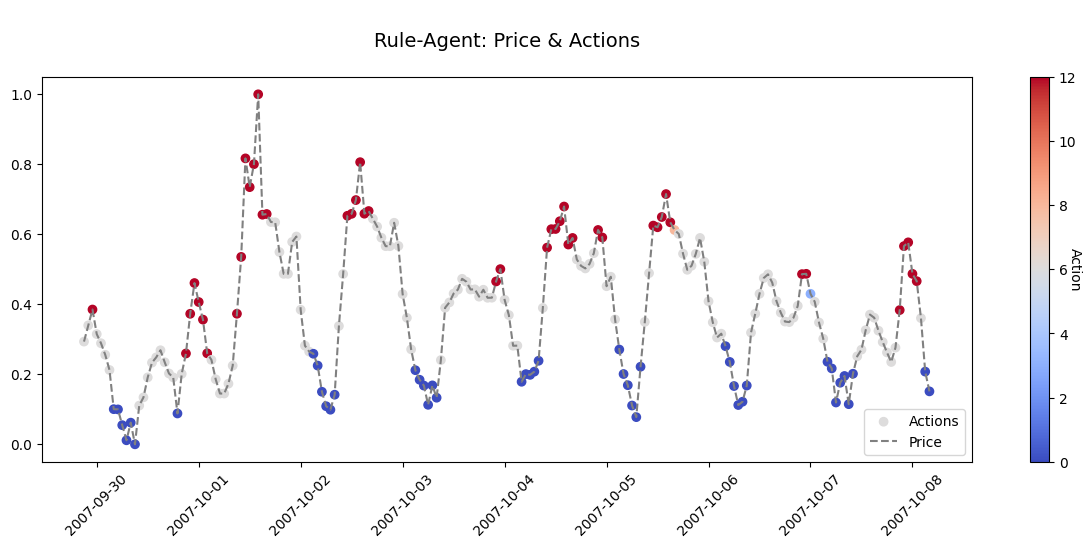

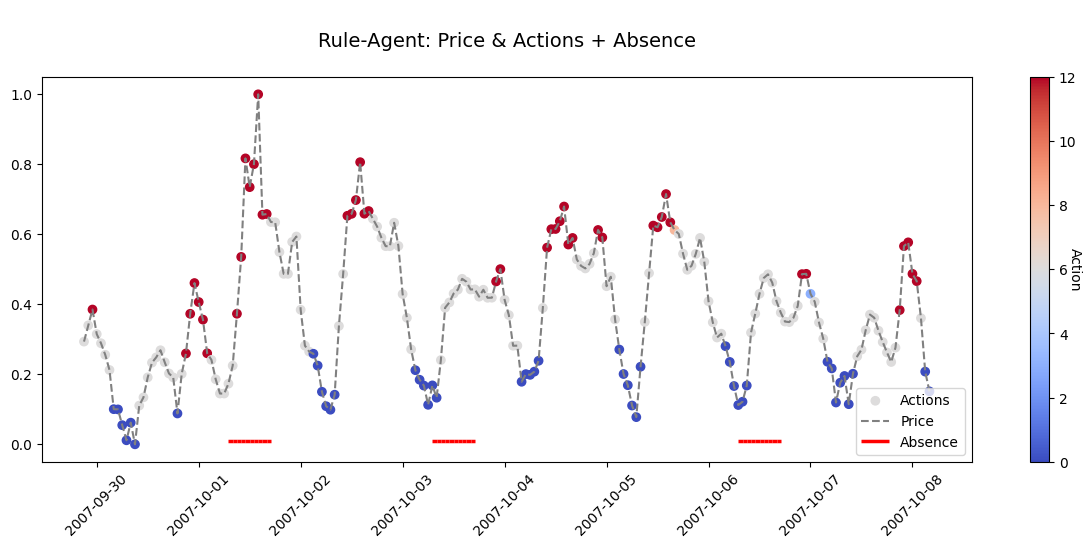

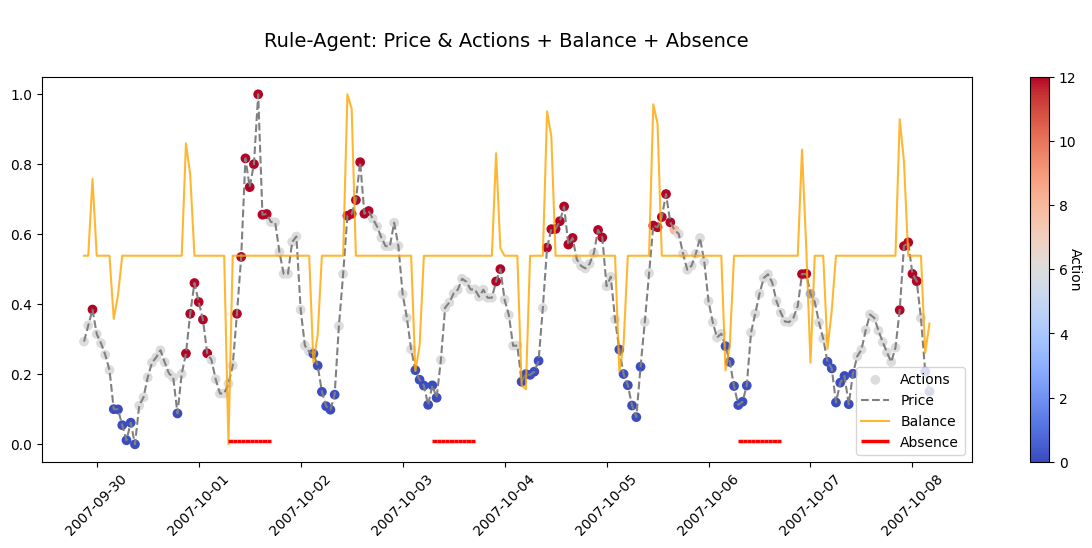

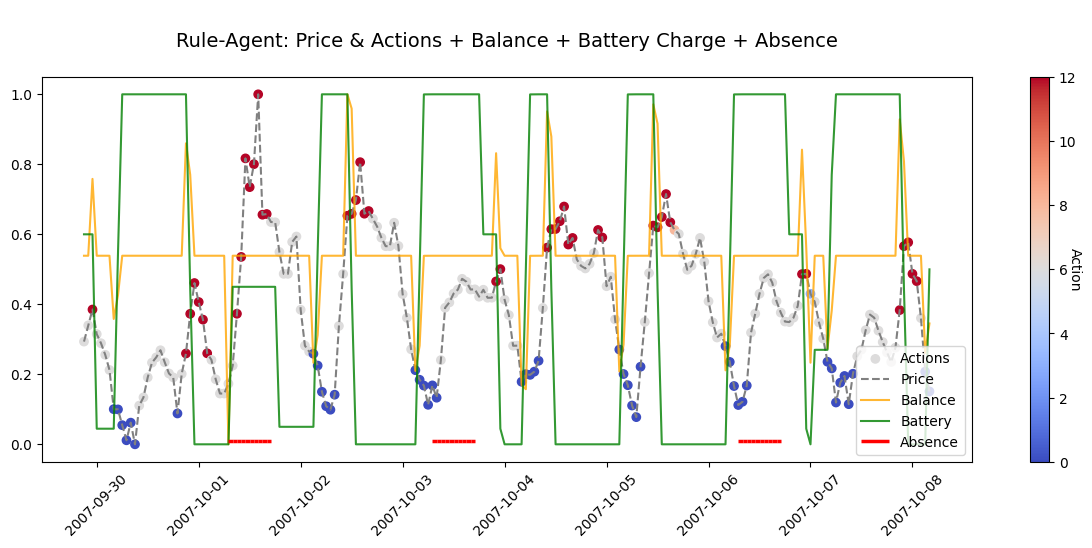

In [38]:
# Visualize Rule-Based Agent
plot_range = (6500, 6700)

#print buy actions
print(f'Buy actions: {len([action for action in eval_rule.actions if action > 6])}')
#print sell actions
print(f'Sell actions: {len([action for action in eval_rule.actions if action < 6])}')

#total balance
print(f'Cumulative balance: {np.sum(eval_rule.balance)}')


# Visualize Rule-Based Agent
plot_range = (0, 100000)
plotter = Plotter(eval_rule, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)

## DDQN AGENT

In [10]:
seed = 2705
rep = 1000000
batch_size = 32
gamma = 0.99
epsilon = 1.0
epsilon_decay = 99999
epsilon_min = 0.05
learning_rate = 1e-4
price_horizon = 48
future_horizon = 0
hidden_dim = 64
action_classes = 9
extra_penalty = False
verbose = False


In [11]:
if TRAIN:
    
    # Initialize Environment
    env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
    env.setup(train, price_horizon=price_horizon, future_horizon=future_horizon, action_classes = action_classes, extra_penalty = extra_penalty)

    #Initialize DQN
    agent = DDQNAgent(env = env, 
                    device = 'cpu', 
                    epsilon_decay = epsilon_decay, 
                    epsilon_start = epsilon, 
                    epsilon_end = epsilon_min, 
                    discount_rate = gamma, 
                    lr = learning_rate, 
                    buffer_size = 50000, 
                    price_horizon = price_horizon, 
                    hidden_dim=hidden_dim,
                    action_classes = action_classes)
        
    obs, info = env.reset() # Reset environment and get initial observation

    episode_balance = 0
    episode_loss = 0
    episode_counter = 0
    episode_reward = 0

    for i in tqdm(range(rep)):
        
        action = agent.choose_action(i, obs['tensor'], greedy = False)
        new_obs,r,t,info = env.step(action)

        # Fill replay buffer - THIS IS THE ONLY THING WE DO WITH THE CURRENT OBSERVATION - LEARNING IS FULLY PERFORMED FROM THE REPLAY BUFFER
        agent.replay_memory.add_data((obs['tensor'], action, r, t, new_obs['tensor']))
        
        #Update DQN
        loss = agent.optimize(batch_size)
        
        # Update values
        episode_balance += info['balance']
        episode_reward += r
        episode_loss += loss
        
        # New observation
        obs = new_obs

        if t:
            obs, info = env.reset()
            episode_counter += 1
            print('Episode ', episode_counter, 'Balance: ', episode_balance, 'Reward: ', episode_reward, 'Loss: ', episode_loss) # Add both balance and reward to see how training objective and actually spent money differ
            episode_loss = 0
            episode_balance = 0
            episode_reward = 0 
            
    # Save agent
    torch.save(agent.dqn_predict.state_dict(), f'models/agent_{action_classes}.pt')

Setup with price horizon:  48  and future horizon:  0  and action space:  9


  3%|▎         | 26335/1000000 [01:04<51:25, 315.57it/s]  

Episode  1 Balance:  -7062.9343518543565 Reward:  -7062.9343518543565 Loss:  3021.001377204433


  5%|▌         | 52582/1000000 [02:47<33:27, 471.87it/s]  

Episode  2 Balance:  -5439.270303733025 Reward:  -5439.270303733025 Loss:  2839.2536327680573


  8%|▊         | 78844/1000000 [03:53<36:16, 423.22it/s]  

Episode  3 Balance:  -3648.554495116232 Reward:  -3648.554495116232 Loss:  2310.3726515225135


 11%|█         | 105078/1000000 [05:02<34:53, 427.52it/s] 

Episode  4 Balance:  -1558.8417692376665 Reward:  -1558.8417692376665 Loss:  1816.4411954411771


 13%|█▎        | 131347/1000000 [06:27<32:37, 443.81it/s]  

Episode  5 Balance:  -952.3698791774459 Reward:  -952.3698791774459 Loss:  1400.6889689650852


 16%|█▌        | 157591/1000000 [07:36<34:14, 410.08it/s]  

Episode  6 Balance:  -990.132484924668 Reward:  -990.132484924668 Loss:  1324.6979697539937


 18%|█▊        | 183858/1000000 [08:54<34:46, 391.08it/s]  

Episode  7 Balance:  -1040.5427276578912 Reward:  -1040.5427276578912 Loss:  1274.943984349491


 21%|██        | 210128/1000000 [10:06<32:28, 405.37it/s]  

Episode  8 Balance:  -931.0205753623346 Reward:  -931.0205753623346 Loss:  1226.2866331557743


 24%|██▎       | 236378/1000000 [11:21<28:05, 453.17it/s]  

Episode  9 Balance:  -920.5981409757773 Reward:  -920.5981409757773 Loss:  1150.5788552218582


 26%|██▋       | 262643/1000000 [12:22<29:00, 423.66it/s]

Episode  10 Balance:  -925.5783936914453 Reward:  -925.5783936914453 Loss:  1103.5334636864718


 29%|██▉       | 288859/1000000 [13:30<34:51, 339.97it/s]  

Episode  11 Balance:  -831.4155893568872 Reward:  -831.4155893568872 Loss:  1084.5715290219523


 32%|███▏      | 315147/1000000 [14:39<32:23, 352.38it/s]  

Episode  12 Balance:  -801.5390515731112 Reward:  -801.5390515731112 Loss:  1135.7741690506227


 34%|███▍      | 341380/1000000 [15:48<24:34, 446.55it/s]  

Episode  13 Balance:  -820.8251698443316 Reward:  -820.8251698443316 Loss:  1190.2794838193804


 37%|███▋      | 367641/1000000 [18:00<27:02, 389.78it/s]  

Episode  14 Balance:  -910.3968863084458 Reward:  -910.3968863084458 Loss:  1148.924170668237


 39%|███▉      | 393893/1000000 [19:19<23:37, 427.54it/s]  

Episode  15 Balance:  -812.833988797443 Reward:  -812.833988797443 Loss:  1096.1257118717767


 42%|████▏     | 420146/1000000 [20:40<24:06, 400.99it/s]  

Episode  16 Balance:  -897.5784156522236 Reward:  -897.5784156522236 Loss:  1068.3888409743086


 45%|████▍     | 446425/1000000 [21:37<19:12, 480.35it/s]

Episode  17 Balance:  -867.8074516234419 Reward:  -867.8074516234419 Loss:  1034.0375534817576


 47%|████▋     | 472646/1000000 [22:46<31:24, 279.79it/s]

Episode  18 Balance:  -1006.8481731578886 Reward:  -1006.8481731578886 Loss:  1027.5845782386605


 50%|████▉     | 498913/1000000 [24:01<19:19, 432.30it/s]

Episode  19 Balance:  -869.9548754145541 Reward:  -869.9548754145541 Loss:  1047.2487156447023


 53%|█████▎    | 525134/1000000 [25:09<30:53, 256.18it/s]

Episode  20 Balance:  -943.0401569858888 Reward:  -943.0401569858888 Loss:  1005.1952290199697


 55%|█████▌    | 551467/1000000 [26:38<16:18, 458.48it/s]  

Episode  21 Balance:  -935.8543182752197 Reward:  -935.8543182752197 Loss:  971.1320758454967


 58%|█████▊    | 577692/1000000 [27:46<15:56, 441.30it/s]

Episode  22 Balance:  -882.6108659887796 Reward:  -882.6108659887796 Loss:  989.2296369005926


 60%|██████    | 603934/1000000 [28:55<23:19, 282.91it/s]

Episode  23 Balance:  -887.5568165933319 Reward:  -887.5568165933319 Loss:  976.0738470389042


 63%|██████▎   | 630203/1000000 [30:02<13:21, 461.12it/s]

Episode  24 Balance:  -890.9867535351128 Reward:  -890.9867535351128 Loss:  898.6753971152939


 66%|██████▌   | 656447/1000000 [31:09<27:32, 207.84it/s]

Episode  25 Balance:  -919.3843830915554 Reward:  -919.3843830915554 Loss:  925.5155865023844


 68%|██████▊   | 682708/1000000 [32:19<12:40, 417.01it/s]

Episode  26 Balance:  -975.2030960952225 Reward:  -975.2030960952225 Loss:  939.344065151643


 71%|███████   | 708959/1000000 [33:25<13:23, 362.24it/s]

Episode  27 Balance:  -921.5151038364446 Reward:  -921.5151038364446 Loss:  932.5119343947154


 74%|███████▎  | 735225/1000000 [34:35<12:40, 348.20it/s]

Episode  28 Balance:  -954.7888334473345 Reward:  -954.7888334473345 Loss:  951.6455429338384


 76%|███████▌  | 761484/1000000 [35:44<09:39, 411.39it/s]

Episode  29 Balance:  -917.3598369062213 Reward:  -917.3598369062213 Loss:  950.5998523973394


 79%|███████▉  | 787762/1000000 [36:50<09:45, 362.41it/s]

Episode  30 Balance:  -868.1285756446641 Reward:  -868.1285756446641 Loss:  928.9360445758794


 81%|████████▏ | 814002/1000000 [38:02<07:06, 436.01it/s]

Episode  31 Balance:  -915.1262243375528 Reward:  -915.1262243375528 Loss:  927.0179890976287


 84%|████████▍ | 840272/1000000 [39:10<06:20, 419.97it/s]

Episode  32 Balance:  -946.3155610910007 Reward:  -946.3155610910007 Loss:  921.7415882297792


 87%|████████▋ | 866512/1000000 [40:14<04:37, 480.39it/s]

Episode  33 Balance:  -886.0873419025573 Reward:  -886.0873419025573 Loss:  928.5102836149745


 89%|████████▉ | 892746/1000000 [41:16<04:32, 393.70it/s]

Episode  34 Balance:  -877.8187342115567 Reward:  -877.8187342115567 Loss:  942.3050572485663


 92%|█████████▏| 919038/1000000 [42:23<03:11, 422.29it/s]

Episode  35 Balance:  -884.3971480291086 Reward:  -884.3971480291086 Loss:  974.8335721432231


 95%|█████████▍| 945286/1000000 [43:23<01:53, 481.50it/s]

Episode  36 Balance:  -974.2267638214457 Reward:  -974.2267638214457 Loss:  983.4756029222626


 97%|█████████▋| 971532/1000000 [44:22<01:00, 469.98it/s]

Episode  37 Balance:  -963.8567314886672 Reward:  -963.8567314886672 Loss:  974.0417209579609


100%|█████████▉| 997819/1000000 [45:20<00:04, 448.05it/s]

Episode  38 Balance:  -866.7889495596672 Reward:  -866.7889495596672 Loss:  949.2497797200922


100%|██████████| 1000000/1000000 [45:25<00:00, 366.96it/s]


In [ ]:
# Initialize Environment (needed for Replay Buffer)
env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
env.setup(train, price_horizon=price_horizon, future_horizon=future_horizon, action_classes = action_classes, extra_penalty = extra_penalty)

# Load agent
agent = DDQNAgent(env = env,
                  device = 'cpu', 
                  epsilon_decay = epsilon_decay, 
                  epsilon_start = epsilon, 
                  epsilon_end = epsilon_min, 
                  discount_rate = gamma, 
                  lr = learning_rate, 
                  buffer_size = 50000, 
                  price_horizon = price_horizon, 
                  hidden_dim=hidden_dim,
                  action_classes = action_classes)

agent.dqn_predict.load_state_dict(torch.load(f'models/agent_{action_classes}.pt'))


Setup with price horizon:  48  and future horizon:  0  and action space:  9


<All keys matched successfully>

In [12]:
# Evaluate DDQN Agent
df = train

ddqn_env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
ddqn_env.setup(train, price_horizon=price_horizon, future_horizon=future_horizon, action_classes = action_classes, extra_penalty = False)
eval_ddqn = DDQNEvaluation(df, ddqn_env)
eval_ddqn.evaluate(agent = agent)

/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.price_horizon to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.price_horizon` for environment variables or `env.get_wrapper_attr('price_horizon')` that will search the reminding wrappers.
  logger.warn(


Setup with price horizon:  48  and future horizon:  0  and action space:  9
Absolute Balance:  -489.13851321622207


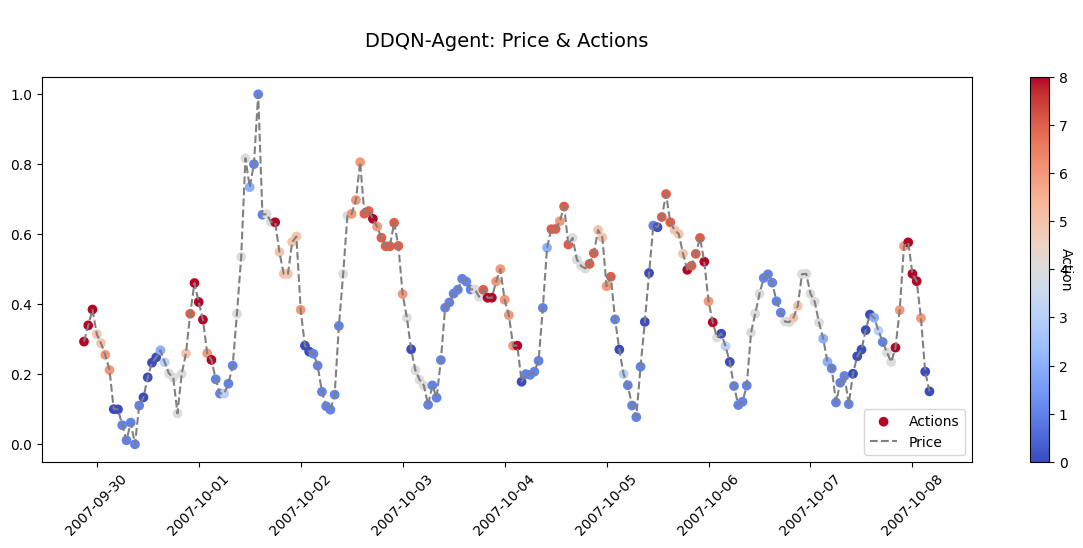

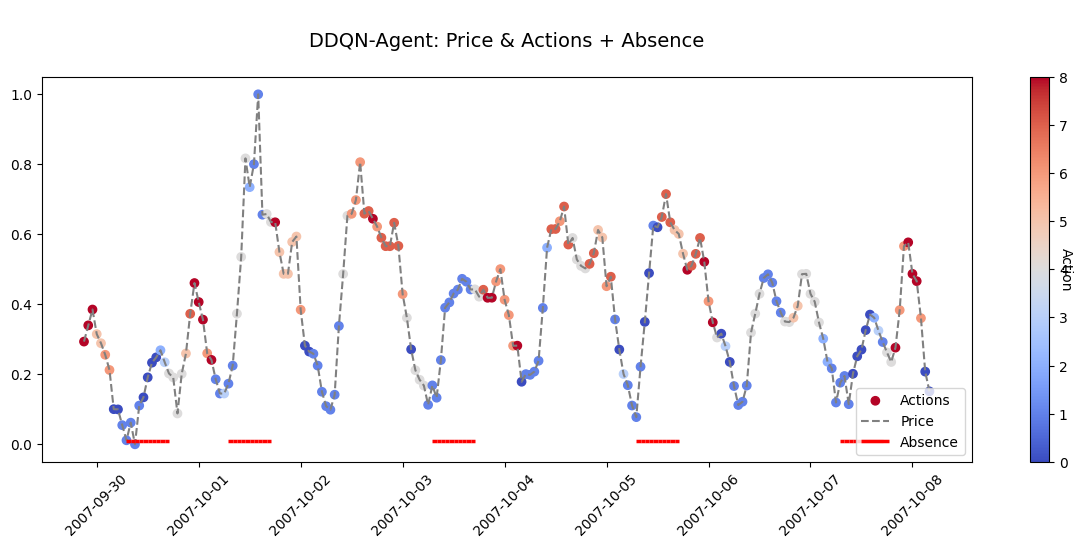

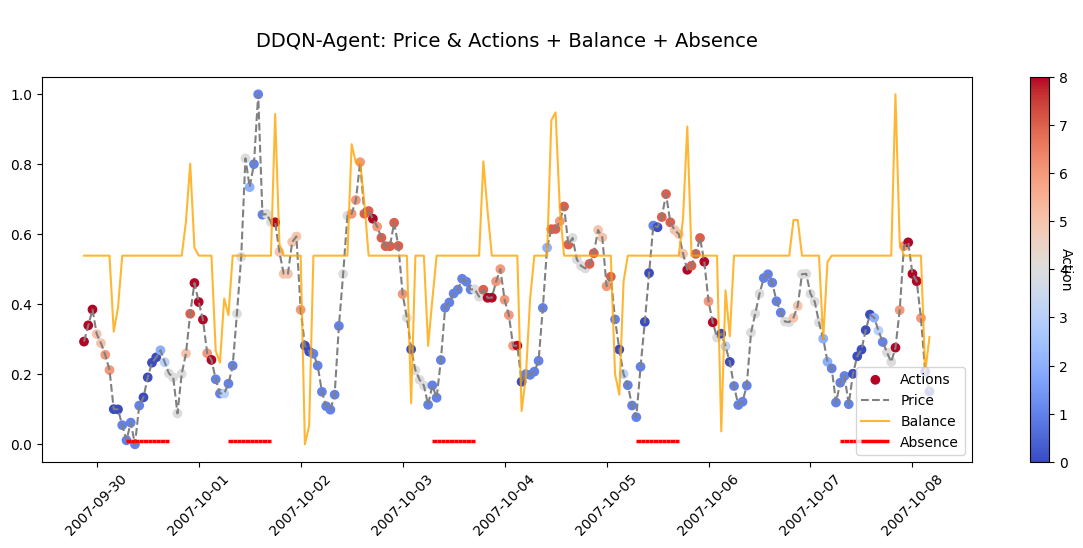

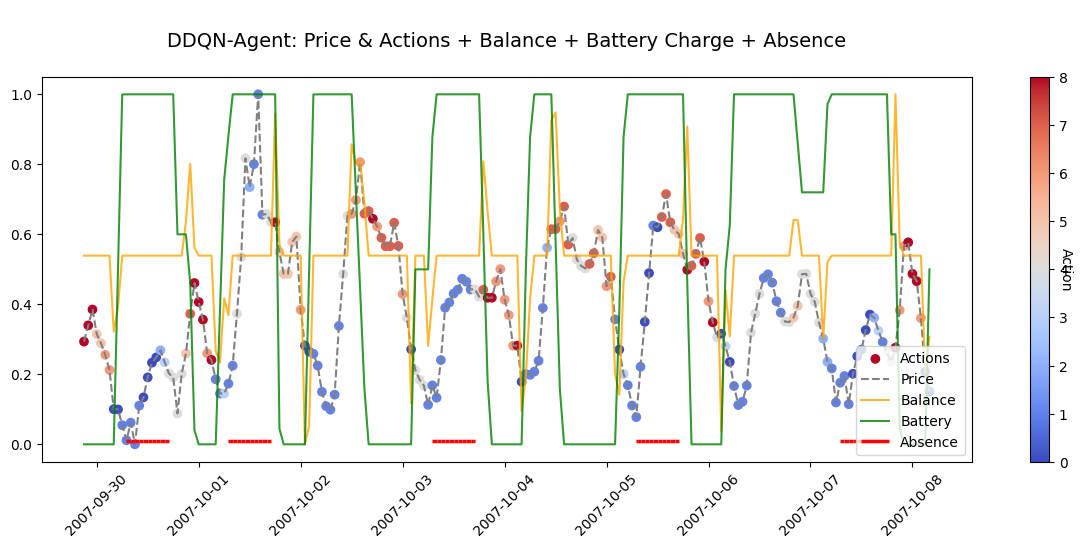

In [37]:
#Visualize DDQN Agent
plot_range = [6500-24, 6700-24]

plotter = Plotter(eval_ddqn, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)

In [10]:
action_classes = 11
test_env = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
test_env.setup(df, price_horizon=price_horizon, extra_penalty = True, action_classes = action_classes, verbose = True)
obs, info = test_env.reset()

for k in range(4):
    for i in reversed(range(action_classes)):
        test_env.step(i)


/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(


Setup with price horizon:  48  and future horizon:  12  and action space:  11
Action space:  Discrete(11) with no action:  5.0 , kWh step:  6.0  and rest:  2.2300000000000004
Current price: 0.028, current hour: 1, current battery charge: 0, current presence: 1, current index: 48

Action 10, Charging 27.77 kWh, balance: 0.0

Current price: 0.0245, current hour: 2, current battery charge: 0, current presence: 1, current index: 49

Action 9, Charging 24.0 kWh, balance: 0.0

Current price: 0.024149999999999998, current hour: 3, current battery charge: 0, current presence: 1, current index: 50

Action 8, Charging 18.0 kWh, balance: 0.0

Current price: 0.01899, current hour: 4, current battery charge: 0, current presence: 1, current index: 51

Action 7, Charging 12.0 kWh, balance: 0.0

Current price: 0.0155, current hour: 5, current battery charge: 0, current presence: 1, current index: 52

Action 6, Charging 6.0 kWh, balance: 0.0

Current price: 0.02311, current hour: 6, current battery cha

# VALIDATION

/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.price_horizon to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.price_horizon` for environment variables or `env.get_wrapper_attr('price_horizon')` that will search the reminding wrappers.
  logger.warn(


Setup with price horizon:  24  and future horizon:  0  and action space:  13
Absolute Balance:  -1081.7682103845555


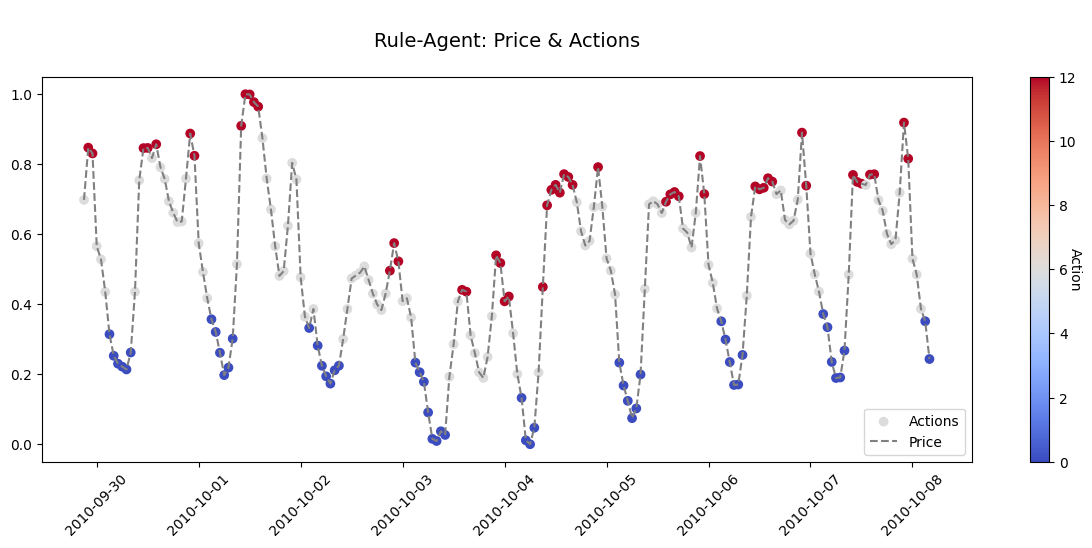

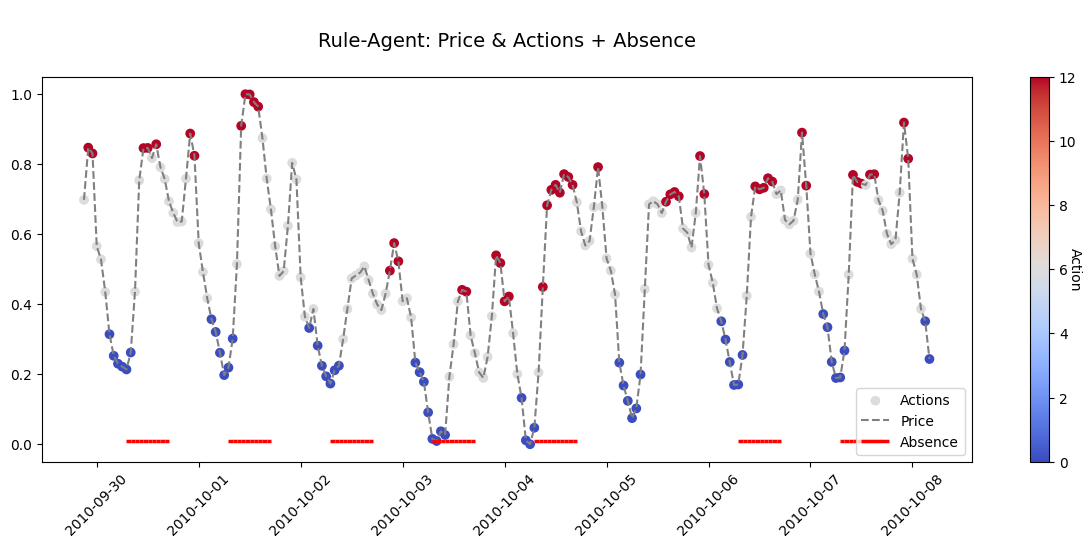

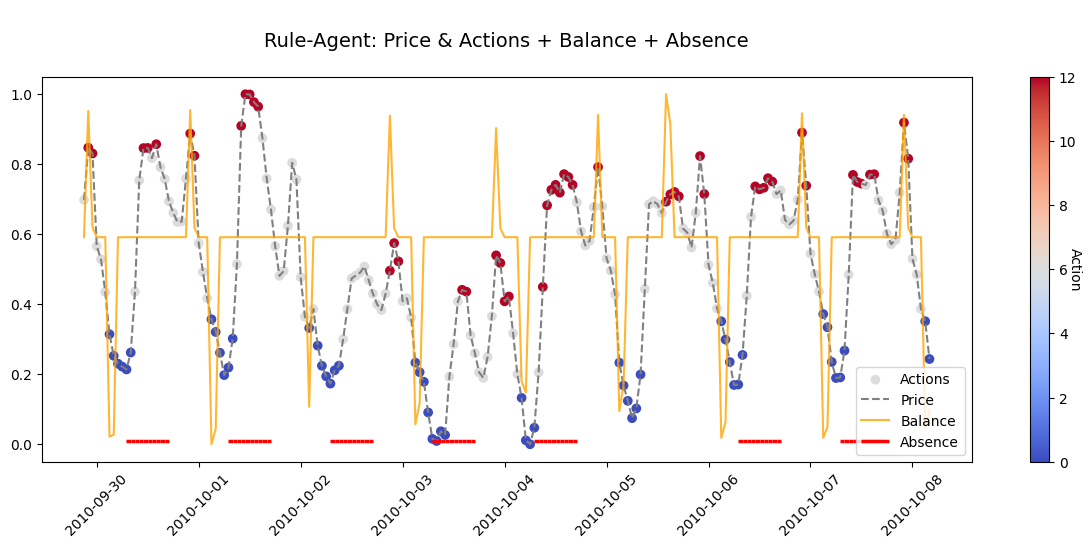

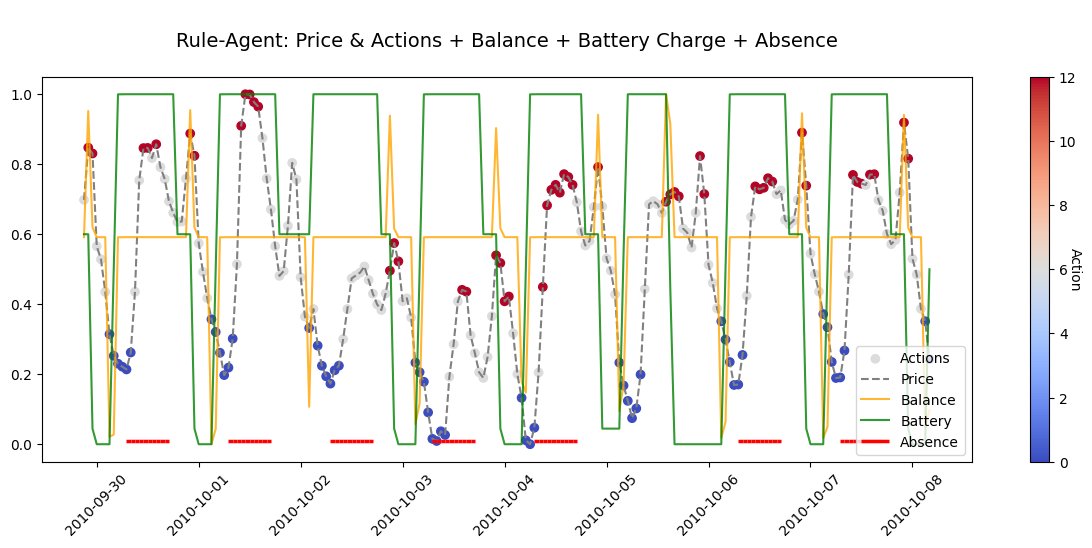

In [31]:
# Evaluate Rule-Based Agent
price_horizon = 24
df = val

rule_env_val = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
rule_env_val.setup(df, price_horizon=price_horizon, action_classes = 13)
eval_rule_val = RuleEvaluation(df, rule_env_val)
eval_rule_val.evaluate(low_quantile = 0.25, high_quantile = 0.75)

#Visualize DDQN Agent
plot_range = [6500, 6700]

plotter = Plotter(eval_rule_val, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)


Setup with price horizon:  48  and future horizon:  0  and action space:  13
Absolute Balance:  -1432.9415739888886


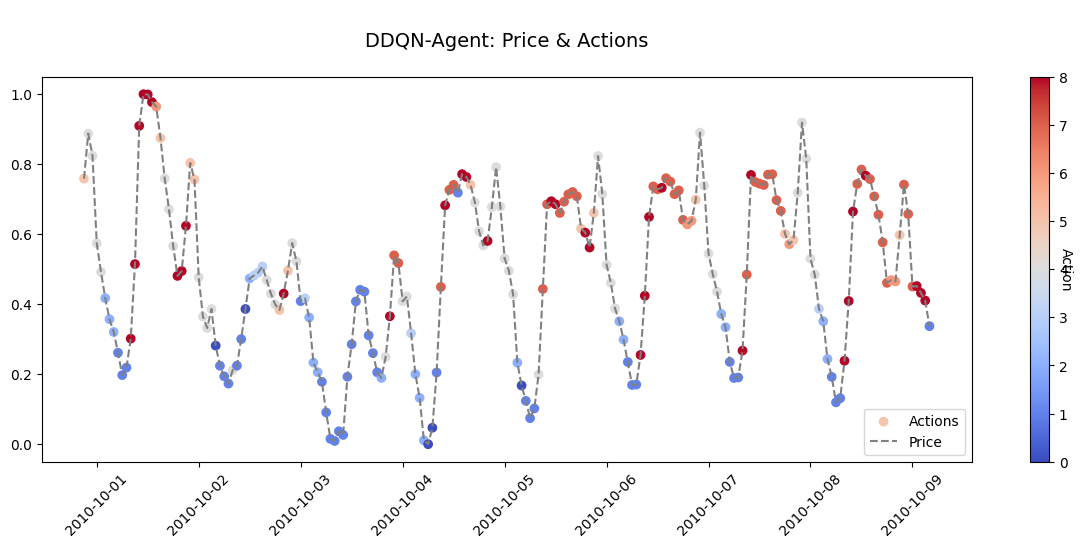

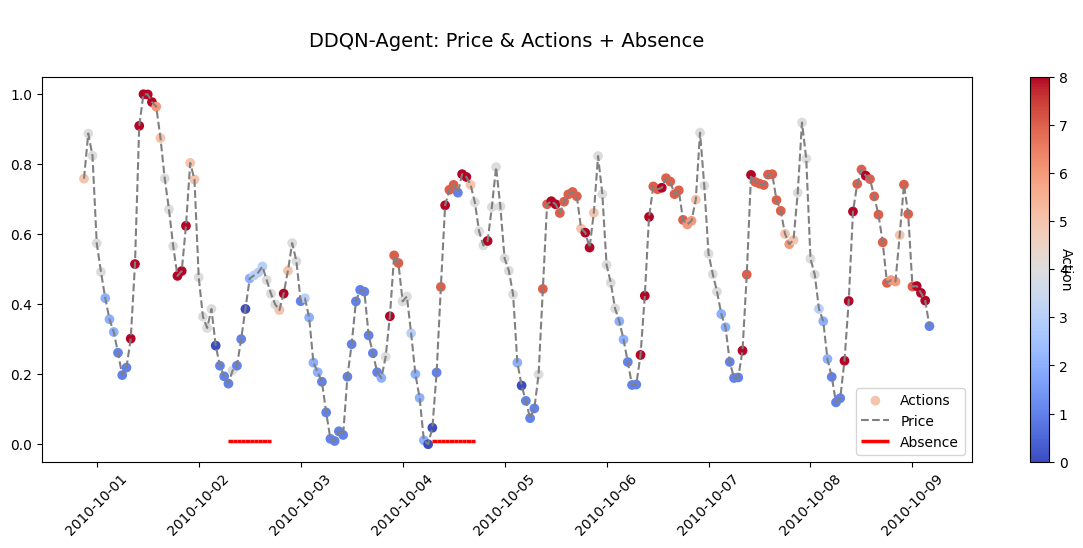

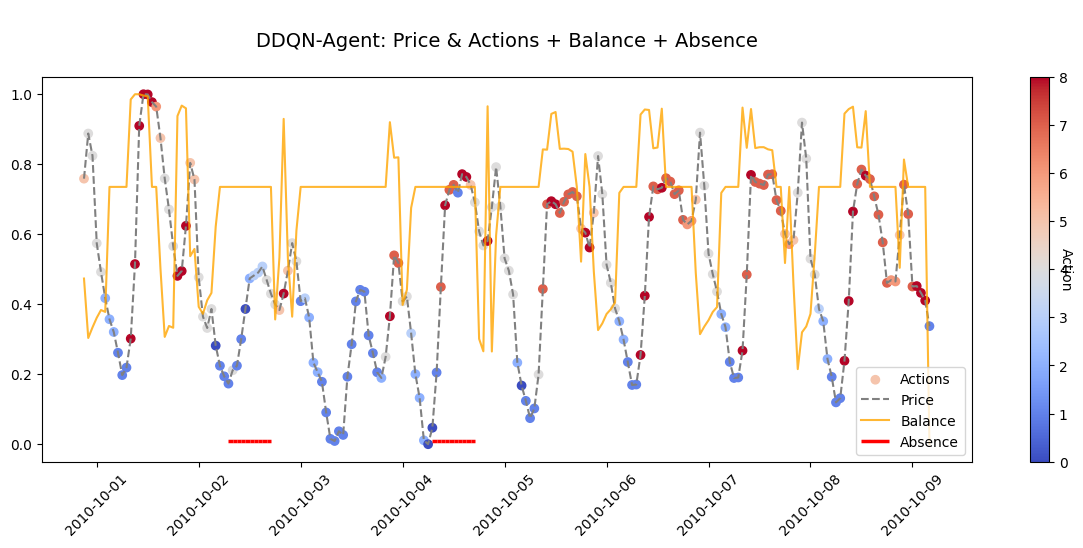

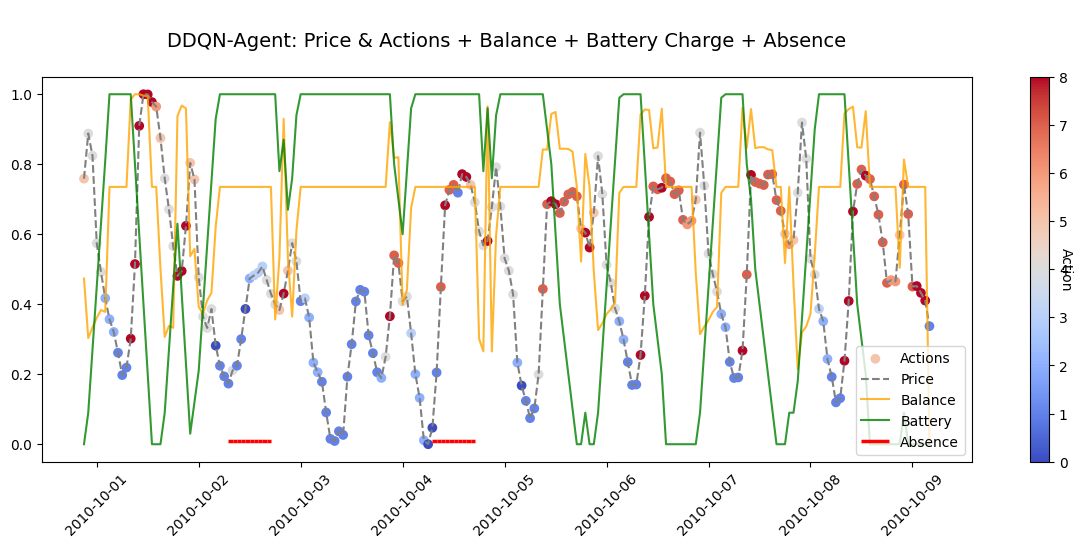

In [32]:
# Evaluate Rule-Based Agent
price_horizon = 48
df = val

ddqn_env_val = gym.make('gym_env/BatteryGrid-v0', disable_env_checker=True)
ddqn_env_val.setup(df, price_horizon=price_horizon, action_classes = 13)
eval_ddqn_val = DDQNEvaluation(df, ddqn_env_val)
eval_ddqn_val.evaluate(agent = agent)

#Visualize DDQN Agent
plot_range = [6500, 6700]

plotter = Plotter(eval_ddqn_val, range = plot_range)
plotter.plot_actions(battery = False, balance=False, absence = False)
plotter.plot_actions(battery = False, balance=False, absence = True)
plotter.plot_actions(battery = False, balance=True, absence = True)
plotter.plot_actions(battery = True, balance=True, absence = True)

In [ ]:
# Reward Shaping:

# when rewards are not sparse, a measure of the uncertainty on
# the value function can be used to guide exploration.



# Replay Buffer:

# Problem: Our RL problem is a sequential one with a fixed starting point and a fixed order where to move. Does this affect the validity of s,a,r,s' for the replay buffer?


In [ ]:
# Feature Engineering: 

# ⁠Gradient of curve 
# Value of to same date last year if available 
# ⁠Moving average on different scale
# ⁠⁠Moving standard deviation  on different scales 
# ⁠⁠Season
# ⁠Day of week
# ⁠⁠Month
# Average historic hourly price
# Hardcoded price boundary (sell when price at previous timestep above threshold, buy when price at previous timestep is below threshold) - this can be a dynamic boundary (per month, per day, …) or a hard boundary 


In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
import pickle
import pandas as pd
import numpy as np
import math
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()


    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)


    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels) # num_channels is a list of the number of channels for each layer 
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)


class TCNModel(nn.Module):
    def __init__(self, seq_len, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(
            num_inputs, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.dense = nn.Linear(seq_len*num_channels[-1], 3)

    def forward(self, x):
        tcn_output = self.tcn(x).flatten(end_dim = -2).t() #Flatten over the features and timestep dimensions, preserve batch dimension
        return self.dense(self.dropout(tcn_output))


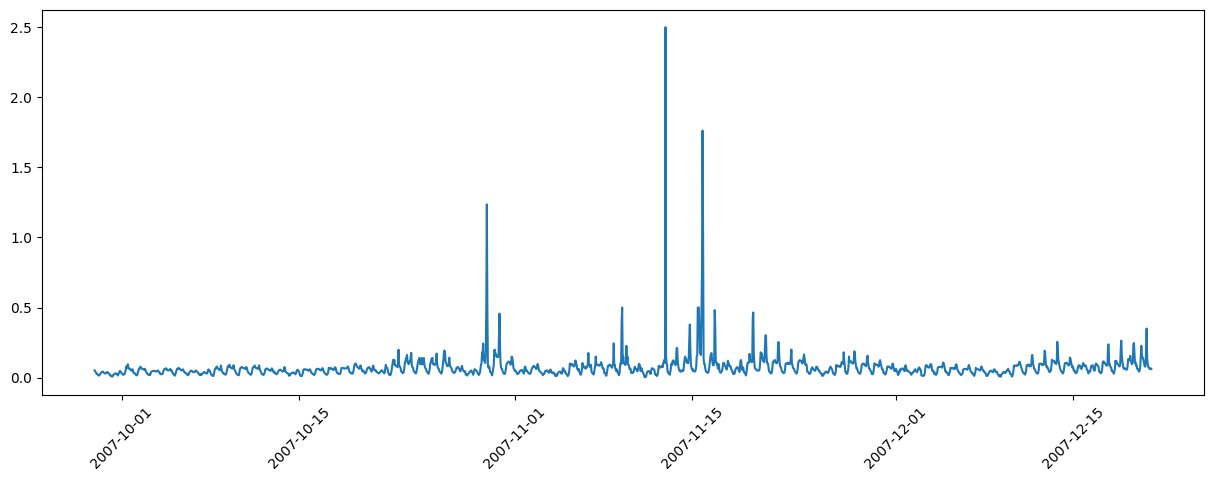

In [ ]:
start = 6500
range = 2000
plt.figure(figsize=(15,5))
plt.plot(train['datetime'][start:(start+range)], train['price'][start:(start+range)])
plt.xticks(rotation=45)
plt.show()

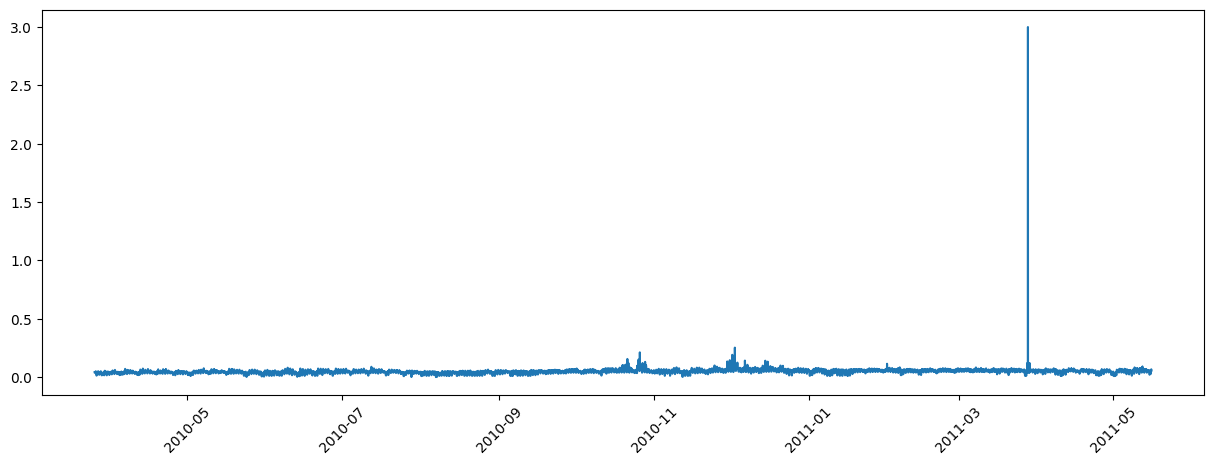

In [ ]:
start = 2000
range = 10000
plt.figure(figsize=(15,5))
plt.plot(val['datetime'][start:(start+range)], val['price'][start:(start+range)])
plt.xticks(rotation=45)
plt.show()

In [ ]:
price_horizon = 48
future_horizon = 0

env = gym.make('gym_env/BatteryGrid-v0')
env.setup(val, price_horizon=price_horizon, future_horizon=future_horizon, verbose=True)
obs,_ = env.reset()
print(obs)

obs,r,t,info = env.step(0)
obs,r,t,info = env.step(1)
obs,r,t,info = env.step(2)
obs,r,t,info = env.step(3)
obs,r,t,info = env.step(4)
obs,r,t,info = env.step(5)
obs,r,t,info = env.step(6)
obs,r,t,info = env.step(7)
obs,r,t,info = env.step(8)
obs,r,t,info = env.step(9)
obs,r,t,info = env.step(10)
obs,r,t,info = env.step(11)




{'battery': -0.5, 'prices': array([-0.76523653, -0.76929427, -0.85788829, -1.01614022, -1.07430118,
       -1.17642101, -1.38336583, -1.59031066, -1.08985586, -1.04183925,
       -0.96947619, -0.74089008, -0.43926462, -0.6421517 , -0.80716652,
       -0.96947619, -0.99449893, -0.38719027, -0.12276077,  0.37498886,
        0.18833275, -0.03957707,  0.60695643,  0.44261789, -0.10247207,
       -0.47781316, -0.36487269, -0.7949933 , -0.9687999 , -0.84706765,
       -0.59954541, -0.06865755,  0.29653919,  0.85244979,  1.17030622,
        1.36440153,  1.52062458,  1.12499477,  0.99649962,  0.70569481,
        0.86191786,  1.50980393,  2.16242404,  2.13266727,  1.41918104,
        1.00123365,  1.25010847,  1.11958445]), 'hour': -0.4583333333333333, 'day': -0.4904109589041096, 'presence': 1, 'tensor': array([-0.5       , -0.76523653, -0.76929427, -0.85788829, -1.01614022,
       -1.07430118, -1.17642101, -1.38336583, -1.59031066, -1.08985586,
       -1.04183925, -0.96947619, -0.74089008, -0.4

/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.setup to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.setup` for environment variables or `env.get_wrapper_attr('setup')` that will search the reminding wrappers.
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:189: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'dict'>`
  logger.warn(
/Users/maxfeucht/anaconda3/envs/PRL/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:213: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  log

In [ ]:
action = 2
kWh = (6 - action) * 5 # Discretize, such that action 0 means most discharge, i.e., kWh = (5 - 0)* 5 = 25
kWh  -= 2.23 if action == 0 else 0 # Add charging loss

print(kWh)

20
